# Lab ML for DS SS23
## Project 2
#### Jan Jascha Jestel (5547158)
#### Mustafa Suman (5564676)
#### Gabriele Inciuraite (5208806)

In [145]:
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
import seaborn as sns

from scipy.io import loadmat
from scipy.spatial.distance import pdist

from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

# 1. Importing the QM7 Dataset

In [12]:
# The QM7 dataset consists of 7165 organic molecules, each of which is composed of up to 23 atoms.
qm7 = loadmat("./qm7.mat")
print(qm7.keys())

dict_keys(['__header__', '__version__', '__globals__', 'X', 'R', 'Z', 'T', 'P'])


In [13]:
# R (7165×23×3) contains for each molecule and atom a triplet representing the 3d coordinates
display(qm7['R'].shape)
display(qm7['R'][0])

(7165, 23, 3)

array([[ 1.886438  , -0.00464873, -0.00823921],
       [ 3.9499245 , -0.00459203,  0.00782347],
       [ 1.1976895 ,  1.9404842 ,  0.00782347],
       [ 1.1849339 , -0.99726516,  1.6593875 ],
       [ 1.2119948 , -0.9589793 , -1.710958  ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.   

In [14]:
# Z (7165×23) contains for each molecule and atom of the molecule the corresponding atomic number

# 0 == no atom at this index
# 1 == hydrogen (H)
# 6 == carbon (C)
# 7 == nitrogen (N) 
# 8 == oxygen (O)
# 16 == sulfur (S)
display(qm7['Z'].shape)
display(qm7['Z'][0])

(7165, 23)

array([6., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0.], dtype=float32)

(1, 7165)

-417.96

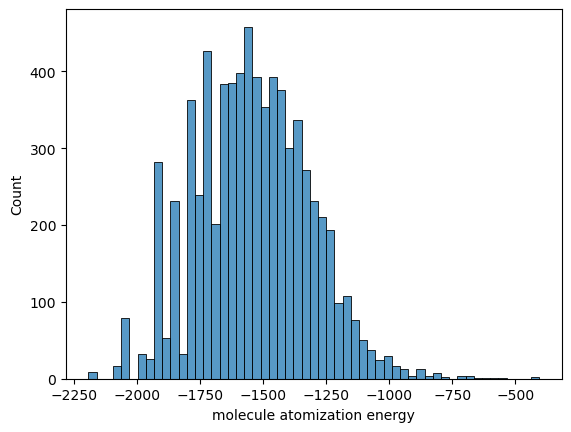

In [15]:
# T (1 x 7165) contains for each molecule the atomization energy (computed via quantum-chemical simulation)
display(qm7['T'].shape)
display(qm7['T'][0, 0])

g = sns.histplot(qm7['T'][0])
g.set_xlabel('molecule atomization energy')
plt.show()

# 1.1 Visualizing Molecules

### "quick and dirty approach"

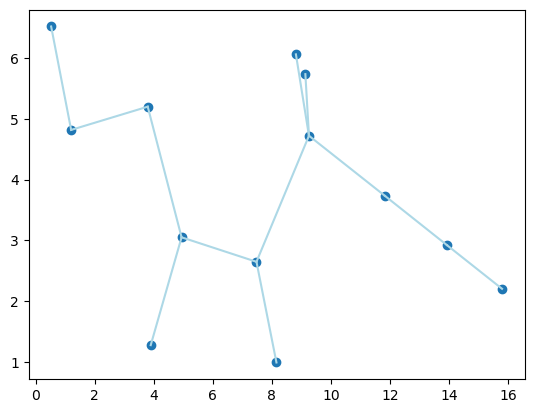

In [18]:
nr = 6400

mol = qm7["R"][nr]
sym = qm7["Z"][nr]

sym = sym[sym > 0]
mol = mol[: len(sym)]

plt.scatter(x=mol[:, 0], y=mol[:, 1])


# generate bonds
thresh = 3

mask = np.argwhere(pdist(mol, metric="euclidean") < thresh)[:, 0]
bonds = np.vstack(np.triu_indices(len(mol), 1)).T[mask]

for i in range(len(bonds)):
    plt.plot(mol[bonds[i]][:, 0], mol[bonds[i]][:, 1], color="lightblue")


### Atomic Simulation Environment

In [37]:
from ase import Atoms
import nglview
import ase.visualize

system = Atoms(positions=mol, symbols=sym)
# ase.visualize.view(system, viewer="x3d")

view = nglview.show_ase(system)
view.add_ball_and_stick() # HOW TO SPECIFY BONDS?????
view

# Other viz approaches
# https://www.kaggle.com/code/mykolazotko/3d-visualization-of-molecules-with-plotly
# nglview

NGLWidget()

# 2. Data Representation, ML Model and Explanations

# 2.1 Data Representation

In [51]:
# one hot encoding of [HCNOS]

# 1 == hydrogen (H)
# 6 == carbon (C)
# 7 == nitrogen (N)
# 8 == oxygen (O)
# 16 == sulfur (S)

z = qm7["Z"].astype(np.int8)

z[z == 1] = 1
z[z == 6] = 2
z[z == 7] = 3
z[z == 8] = 4
z[z == 16] = 5

Z_hot = np.eye(6)[z]
Z_hot = Z_hot[:, :, 1:]  # drop 0 dimension

# sum of to create the representation
x = np.sum(Z_hot, axis=1).astype(int)

print("Shape:", x.shape)
print("Resulting representations:")
print(x)


Shape: (7165, 5)
Resulting representations:
[[ 4  1  0  0  0]
 [ 6  2  0  0  0]
 [ 4  2  0  0  0]
 ...
 [ 9  6  1  0  0]
 [10  7  0  0  0]
 [12  7  0  0  0]]


# 2.2 Ridge Regression Model

In [52]:
# split train / test 
X_train, X_test, y_train, y_test = train_test_split(x, qm7['T'][0], test_size=0.3, random_state=42)

# center data and target
X_train_mean = np.mean(X_train, axis=0)
y_train_mean = np.mean(y_train)

X_train = X_train - X_train_mean
X_test = X_test - X_train_mean

y_train = y_train - y_train_mean
y_test = y_test - y_train_mean

In [129]:
# Grid search to tune alpha using 10-fold cross validation

ridge = Ridge()
alpha_values = np.logspace(np.log10(1e-4), np.log10(100), num=100)
grid = dict(alpha=alpha_values)
search = GridSearchCV(
    ridge,
    grid,
    scoring=("neg_mean_absolute_error"), # 'r2', 'neg_mean_squared_error'
    cv=10,
    n_jobs=-1,
    refit="neg_mean_absolute_error",
    return_train_score=True,
)  

results = search.fit(X_train, y_train)


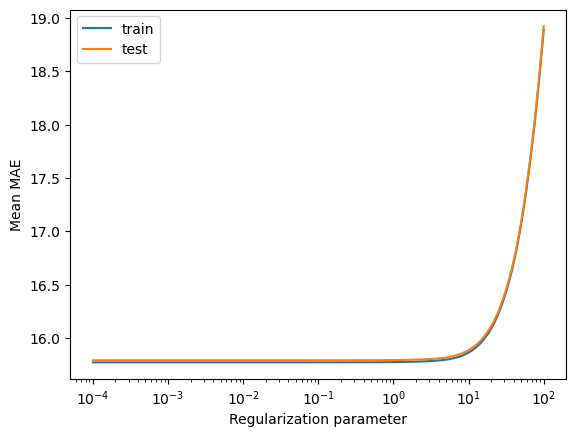

In [152]:
ax = sns.lineplot(x=alpha_values, y = -results.cv_results_['mean_train_score'], label='train')
ax = sns.lineplot(x=alpha_values, y = -results.cv_results_['mean_test_score'], label='test')
ax.set_xscale('log')
ax.set_xlabel('Regularization parameter')
ax.set_ylabel('Mean MAE')
plt.legend(loc='upper left')
plt.show()

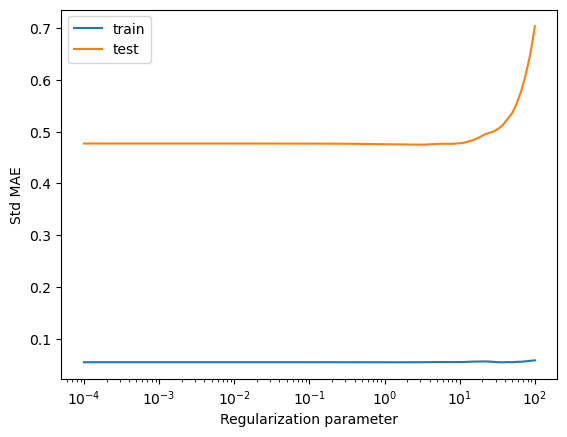

In [153]:
ax = sns.lineplot(x=alpha_values, y = results.cv_results_['std_train_score'], label='train')
ax = sns.lineplot(x=alpha_values, y = results.cv_results_['std_test_score'], label='test')
ax.set_xscale('log')
ax.set_xlabel('Regularization parameter')
ax.set_ylabel('Std MAE')
plt.legend(loc='upper left')
plt.show()

Best parameter: {'alpha': 0.0001}
R2: 0.992
MAE: 15.461
MSE: 403.582


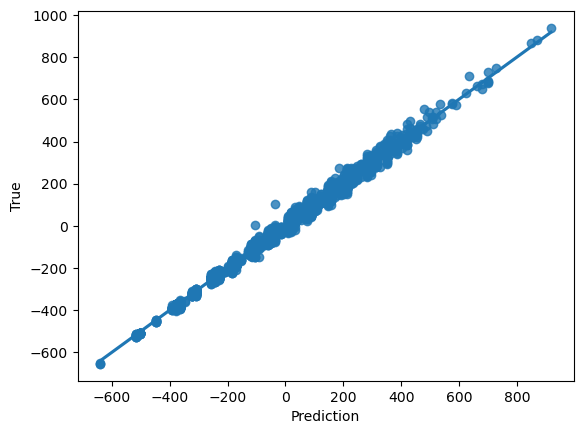

In [175]:
y_pred = search.best_estimator_.predict(X_test)
print("Best parameter:", results.best_params_)
print(f"R2: {r2_score(y_test, y_pred):.3f}")
print(f"MAE: {mean_absolute_error(y_test, y_pred):.3f}")
print(f"MSE: {mean_squared_error(y_test, y_pred):.3f}")
g = sns.regplot(x=y_pred, y=y_test)
g.set_xlabel("Prediction")
g.set_ylabel("True")
plt.show()


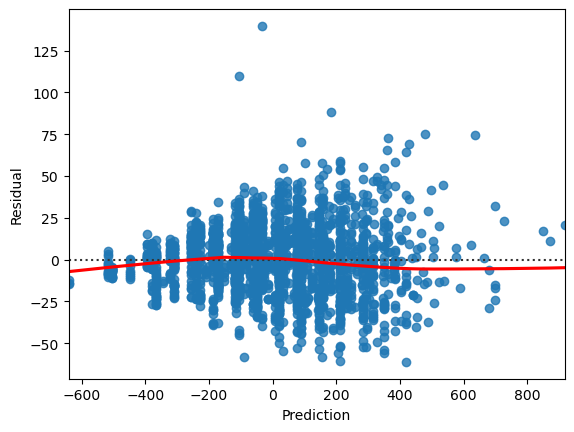

In [176]:
g = sns.residplot(x=y_pred, y=y_test, lowess=True, line_kws=dict(color="r"))
g.set_xlabel("Prediction")
g.set_ylabel("Residual")
plt.show()


# 2.3 Deeper Insights with Explanations + 3 Experiments + 3.1 Simple atom-based Representation
# Isn't that what we already did before?

In [22]:
print("MSE =", mean_absolute_error(y_test, model.predict(X_test)))
print("Ri =", model.coef_)


MSE = 15.460764787547868
Ri = [ -68.68727171 -157.40740317 -102.41317782 -101.15313225  -80.5394613 ]


<AxesSubplot: >

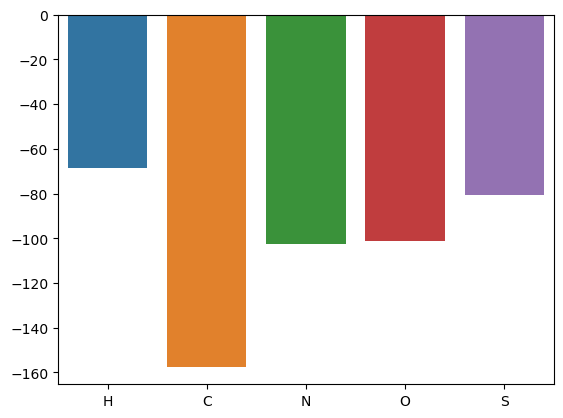

In [23]:
sns.barplot(x=["H", "C", "N", "O", "S"], y=model.coef_)
# TODO Compare the produced insights with existing chemical knowledge or the literature.

# TEST FOR 3.2 Models with Pairs of Atoms

In [171]:
from scipy.spatial.distance import pdist
from scipy.stats import norm
from itertools import combinations_with_replacement, combinations

In [193]:
theta_1 = 2
theta_m = 4
m = 100

intervals = np.linspace(theta_1, theta_m, m)

interval_size = ((theta_m - theta_1) / (m - 1))

interval_centeres = intervals[:-2] + interval_size

d = {c: i for i, c in enumerate(combinations_with_replacement([1, 2, 3, 4, 5], r=2))}

In [194]:
# LOOP OVER ALL MOLECULES TODO think about speed improvement

reps = np.zeros((len(z), m * len(d)))
for i in range(len(z)):
    sym = z[i]
    sym = sym[sym != 0]
    mol = qm7["R"][i][: len(sym)]

    dist = pdist(mol, metric="euclidean")

    # which index for phi A needs to be 1 if we use hard indicator function
    indices = np.floor((dist - theta_1) / interval_size).astype(int)

    phi_A_E = np.zeros((len(indices), m), dtype=int)
    phi_A_E[tuple(np.array(list(zip(range(len(indices)), indices[indices < m]))).T)] = 1

    phi_A_E_soft = np.zeros(phi_A_E.shape)
    for j, mu in enumerate(interval_centeres):
        phi_A_E_soft[:, j] = norm.pdf(dist, loc=mu, scale=0.5)


    for k, c in enumerate(combinations(sym, r=2)):
        # phi_B_Ei
        phi_B_Ei = np.zeros(15).astype(int)
        try:
            phi_B_Ei[d[c]] = 1
        except KeyError:
            phi_B_Ei[d[c[1], c[0]]] = 1

        phi_Ei = phi_A_E_soft[k][:, None] * phi_B_Ei
        reps[i, :] += phi_Ei.flatten()


In [195]:
# split train / test 
X_train, X_test, y_train, y_test = train_test_split(reps, qm7['T'][0], test_size=0.3, random_state=42)

# center data and target
X_train_mean = np.mean(X_train, axis=0)
y_train_mean = np.mean(y_train)

X_train = X_train - X_train_mean
X_test = X_test - X_train_mean

y_train = y_train - y_train_mean
y_test = y_test - y_train_mean

In [197]:
model = Ridge(alpha = 1e-6)
model.fit(X_train, y_train)
mean_absolute_error(y_test, model.predict(X_test))

6.7786040744964815